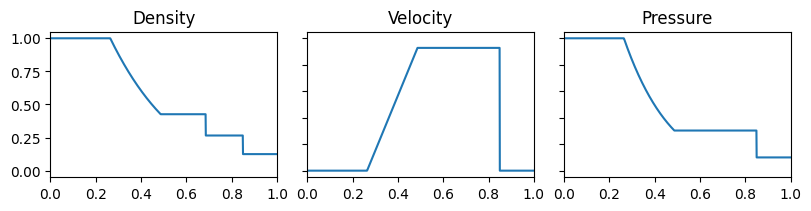

In [5]:
## FROM https://physics.stackexchange.com/questions/423758/how-to-get-exact-solution-to-sod-shock-tube-test
# Libraries
import numpy as np
from scipy.optimize import newton
import matplotlib.pyplot as plt

# Function to find the roots of!
def f(P, pL, pR, cL, cR, gg):
    a = (gg-1)*(cR/cL)*(P-1)
    b = np.sqrt( 2*gg*(2*gg + (gg+1)*(P-1) ) )
    return P - pL/pR*( 1 - a/b )**(2.*gg/(gg-1.))

# Analtyic Sol to Sod Shock
def SodShockAnalytic(rL, uL, pL, rR, uR, pR, xs, x0, T, gg):
    # rL, uL, pL, rR, uR, pR : Initial conditions of the Reimann problem
    # xs: position array (e.g. xs = [0,dx,2*dx,...,(Nx-1)*dx])
    # x0: THIS IS AN INDEX! the array index where the interface sits.
    # T: the desired solution time
    # gg: adiabatic constant 1.4=7/5 for a 3D diatomic gas
    dx = xs[1];
    Nx = len(xs)
    v_analytic = np.zeros((3,Nx),dtype='float64')

    # compute speed of sound
    cL = np.sqrt(gg*pL/rL);
    cR = np.sqrt(gg*pR/rR);
    # compute P
    P = newton(f, 0.5, args=(pL, pR, cL, cR, gg), tol=1e-12);

    # compute region positions right to left
    # region R
    c_shock = uR + cR*np.sqrt( (gg-1+P*(gg+1)) / (2*gg) )
    x_shock = x0 + int(np.floor(c_shock*T/dx))
    v_analytic[0,x_shock-1:] = rR
    v_analytic[1,x_shock-1:] = uR
    v_analytic[2,x_shock-1:] = pR

    # region 2
    alpha = (gg+1)/(gg-1)
    c_contact = uL + 2*cL/(gg-1)*( 1-(P*pR/pL)**((gg-1.)/2/gg) )
    x_contact = x0 + int(np.floor(c_contact*T/dx))
    v_analytic[0,x_contact:x_shock-1] = (1 + alpha*P)/(alpha+P)*rR
    v_analytic[1,x_contact:x_shock-1] = c_contact
    v_analytic[2,x_contact:x_shock-1] = P*pR

    # region 3
    r3 = rL*(P*pR/pL)**(1/gg);
    p3 = P*pR;
    c_fanright = c_contact - np.sqrt(gg*p3/r3)
    x_fanright = x0 + int(np.ceil(c_fanright*T/dx))
    v_analytic[0,x_fanright:x_contact] = r3;
    v_analytic[1,x_fanright:x_contact] = c_contact;
    v_analytic[2,x_fanright:x_contact] = P*pR;

    # region 4
    c_fanleft = -cL
    x_fanleft = x0 + int(np.ceil(c_fanleft*T/dx))
    u4 = 2 / (gg+1) * (cL + (xs[x_fanleft:x_fanright]-xs[x0])/T )
    v_analytic[0,x_fanleft:x_fanright] = rL*(1 - (gg-1)/2.*u4/cL)**(2/(gg-1));
    v_analytic[1,x_fanleft:x_fanright] = u4;
    v_analytic[2,x_fanleft:x_fanright] = pL*(1 - (gg-1)/2.*u4/cL)**(2*gg/(gg-1));

    # region L
    v_analytic[0,:x_fanleft] = rL
    v_analytic[1,:x_fanleft] = uL
    v_analytic[2,:x_fanleft] = pL

    return v_analytic

# Physics
gg=1.4  # gamma = C_v / C_p = 7/5 for ideal gas
rL, uL, pL =  1.0,  0.0, 1;
rR, uR, pR = 0.125, 0.0, .1;

# Set Disretization
Nx = 1000
X = 1.
dx = X/(Nx-1)
xs = np.linspace(0,X,Nx)
x0 = Nx//2
T = 0.2

analytic = SodShockAnalytic(rL, uL, pL, rR, uR, pR, xs, x0, T, gg)

fig, axs = plt.subplots(1,3,figsize=(8,2), layout='constrained')
axs[0].set_title("Density")
axs[0].plot(xs,analytic[0].T)
axs[1].set_title("Velocity")
axs[1].plot(xs,analytic[1].T)
axs[1].set_yticks([0.,.2,.4,.6,.8,1.],['','','','','',''])
axs[2].set_title("Pressure")
axs[2].plot(xs,analytic[2].T)
axs[2].set_yticks([0.,.2,.4,.6,.8,1.],['','','','','',''])
for i in range(3):
    axs[i].set_xlim([0.,1.])
    axs[i].set_ylim([-.05,1.05])

# Save density and x positions to a file
np.savetxt('density_and_x_positions.txt', np.column_stack((xs, analytic[0])), header='x_position density', comments='', fmt='%.6f')
